# Problem Statement

Predicting Survival in the Titanic Data Set
We will be using a decision tree to make predictions about the Titanic data set from
Kaggle. This data set provides information on the Titanic passengers and can be used to
predict whether a passenger survived or not.

In [258]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from scipy.stats import mode
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [259]:
url="https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv"

Renaming the columns

In [260]:
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp',
                  'Parch','Ticket','Fare','Cabin','Embarked']

In [261]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


You use only Pclass, Sex, Age, SibSp (Siblings aboard), Parch (Parents/children aboard),
and Fare to predict whether a passenger survived.

In [262]:
titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

In [263]:
titanic.shape

(891, 7)

In [264]:
titanic.nunique()

Survived      2
Pclass        3
Sex           2
Age          88
SibSp         7
Parch         7
Fare        248
dtype: int64

In [265]:
titanic.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

Age has 177 nan values which need to be filled.

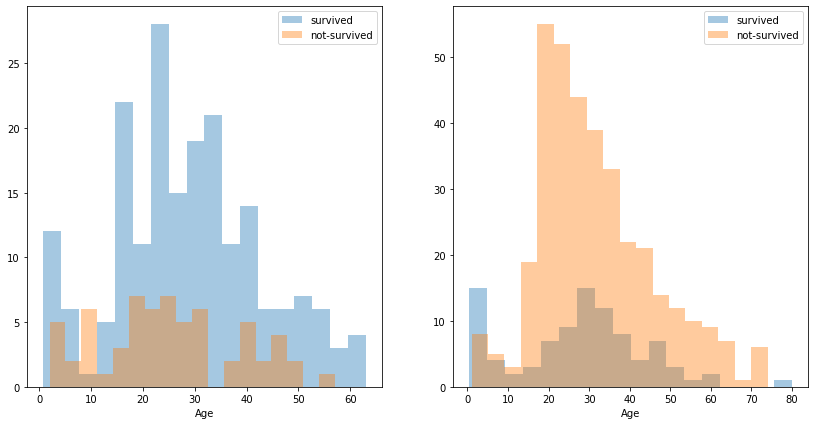

In [266]:
women = titanic[titanic['Sex'] == 'female']
men = titanic[titanic['Sex'] == 'male']
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
ax = sb.distplot(women[women['Survived'] == 1].Age.dropna(), bins=18, label = 'survived', ax = axes[0], 
                  kde =False)
ax = sb.distplot(women[women['Survived'] == 0].Age.dropna(), bins=18, label = 'not-survived', ax = axes[0], 
                  kde =False)
ax.legend()
ax = sb.distplot(men[men['Survived'] == 1].Age.dropna(), bins=18, label = 'survived', ax = axes[1], 
                  kde =False)
ax = sb.distplot(men[men['Survived'] == 0].Age.dropna(), bins=18, label = 'not-survived', ax = axes[1], 
                  kde =False)
ax.legend()

<AxesSubplot:xlabel='Survived', ylabel='count'>

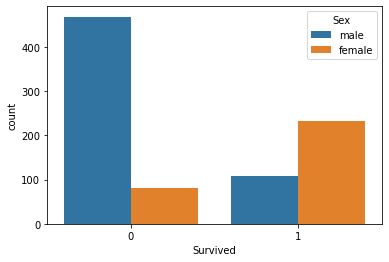

In [267]:
sb.countplot(x='Survived', hue='Sex', data=titanic)

Since the male to female survivor ratio is different so we will impute nan values differently for men and women also further on survivors and non survivors

In [268]:
women_survivor_age = titanic.index[(titanic['Sex']=='female') & 
                                   (titanic['Age'].isnull()) & (titanic['Survived']==1)]
print(women_survivor_age)
women_survivor_mean = titanic[(titanic['Sex']=='female') & (titanic['Survived']==1)].Age.mean()
titanic.loc[women_survivor_age, 'Age'] = titanic.loc[women_survivor_age]['Age'].fillna(women_survivor_mean)

Int64Index([ 19,  28,  31,  32,  47,  82, 109, 128, 166, 186, 198, 241, 256,
            274, 300, 303, 306, 330, 334, 347, 358, 359, 367, 368, 375, 431,
            457, 533, 573, 596, 612, 653, 669, 697, 727, 849],
           dtype='int64')


In [269]:
women_nonsurvivor_age = titanic.index[(titanic['Sex']=='female') & 
                                   (titanic['Age'].isnull()) & (titanic['Survived']==0)]
print(women_nonsurvivor_age)
women_nonsurvivor_mean = titanic[(titanic['Sex']=='female') & (titanic['Survived']==0)].Age.mean()
titanic.loc[women_nonsurvivor_age,'Age'] = titanic.loc[women_nonsurvivor_age]['Age'].fillna(women_nonsurvivor_mean)

Int64Index([140, 180, 229, 235, 240, 264, 409, 415, 485, 502, 564, 578, 593,
            680, 792, 863, 888],
           dtype='int64')


In [270]:
men_survivor_age = titanic.index[(titanic['Sex']=='male') & 
                                   (titanic['Age'].isnull()) & (titanic['Survived']==1)]
print(men_survivor_age)
men_survivor_mean = titanic[(titanic['Sex']=='male') & (titanic['Survived']==1)].Age.mean()
titanic.loc[men_survivor_age, 'Age'] = titanic.loc[men_survivor_age]['Age'].fillna(men_survivor_mean)

Int64Index([17, 36, 55, 65, 107, 298, 301, 444, 507, 547, 643, 692, 709, 740,
            828, 839],
           dtype='int64')


In [271]:
men_nonsurvivor_age = titanic.index[(titanic['Sex']=='male') & 
                                   (titanic['Age'].isnull()) & (titanic['Survived']==0)]
print(men_nonsurvivor_age)
men_nonsurvivor_mean = titanic[(titanic['Sex']=='male') & (titanic['Survived']==0)].Age.mean()
men_nonsurvivor_mean
titanic.loc[men_nonsurvivor_age, 'Age'] = titanic.loc[men_nonsurvivor_age]['Age'].fillna(men_nonsurvivor_mean)


Int64Index([  5,  26,  29,  42,  45,  46,  48,  64,  76,  77,
            ...
            793, 815, 825, 826, 832, 837, 846, 859, 868, 878],
           dtype='int64', length=108)


In [272]:
onehotencoder = preprocessing.OneHotEncoder()
X = onehotencoder.fit_transform(titanic['Sex'].values.reshape(-1,1)).toarray()
df = pd.DataFrame(X.astype(int), columns=['male', 'female'])
df.head()
titanic = pd.concat([titanic, df], axis=1)
titanic.drop(['Sex'], axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,female
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1


In [273]:
X = onehotencoder.fit_transform(titanic['Pclass'].values.reshape(-1,1)).toarray()
df = pd.DataFrame(X.astype(int))
df.head()
titanic = pd.concat([titanic, df], axis=1)
titanic.drop(['Pclass'], axis=1, inplace=True)
titanic.head()

,Survived,Age,SibSp,Parch,Fare,male,female,0,1,2
0,0,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1


In [274]:
titanic.isnull().sum()

Survived    0
Age         0
SibSp       0
Parch       0
Fare        0
male        0
female      0
0           0
1           0
2           0
dtype: int64

In [275]:
titanic['Age'] = titanic['Age'].astype(int)
titanic.loc[ titanic['Age'] <= 11, 'Age'] = 0
titanic.loc[(titanic['Age'] > 11) & (titanic['Age'] <= 18), 'Age'] = 1
titanic.loc[(titanic['Age'] > 18) & (titanic['Age'] <= 22), 'Age'] = 2
titanic.loc[(titanic['Age'] > 22) & (titanic['Age'] <= 27), 'Age'] = 3
titanic.loc[(titanic['Age'] > 27) & (titanic['Age'] <= 33), 'Age'] = 4
titanic.loc[(titanic['Age'] > 33) & (titanic['Age'] <= 40), 'Age'] = 5
titanic.loc[(titanic['Age'] > 40) & (titanic['Age'] <= 66), 'Age'] = 6
titanic.loc[ titanic['Age'] > 66, 'Age'] = 6

In [276]:
titanic.head()

,Survived,Age,SibSp,Parch,Fare,male,female,0,1,2
0,0,2,1,0,7.2500,0,1,0,0,1
1,1,5,1,0,71.2833,1,0,1,0,0
2,1,3,0,0,7.9250,1,0,0,0,1
3,1,5,1,0,53.1000,1,0,1,0,0
4,0,5,0,0,8.0500,0,1,0,0,1


In [277]:
X = titanic.drop("Survived",axis=1)
y = titanic["Survived"]

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [279]:
logmodel = LogisticRegression(max_iter=250)
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=250)

In [280]:
predictions = logmodel.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       154
           1       0.80      0.65      0.71       114

    accuracy                           0.78       268
   macro avg       0.78      0.76      0.77       268
weighted avg       0.78      0.78      0.78       268



In [281]:
confusion_matrix(y_test, predictions)

array([[135,  19],
       [ 40,  74]])